# Introduction
This colab worksheet provides a starting point for Task 1 (the natural language processing assignment).

In [ ]:
# Imports & Reproducibility
import os
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Used NLTK resources
nltk.download('stopwords')  # For stopword removal
nltk.download('wordnet')    # For lemmatization
nltk.download('omw-1.4')    # WordNet corpora

# Reproducibility: seed all sources of randomness
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Data Loading

In [ ]:
# Download the data

import os, subprocess, pandas as pd, numpy as np

if not os.path.exists('spam_detection_training_data.csv'):
    !wget "https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n" \
          -O spam_detection_training_data.csv
if not os.path.exists('spam_detection_test_data.csv'):
    !wget "https://sussex.box.com/shared/static/2a1am3esr4yzjmqr172vua1t41a846e0" \
          -O spam_detection_test_data.csv

--2025-05-13 14:17:07--  https://sussex.box.com/shared/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-13 14:17:07--  https://sussex.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n [following]
--2025-05-13 14:17:07--  https://sussex.app.box.com/public/static/qdmzn1esyjk6hwa4gy9y5y0tp0fpcr0n
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('ascii')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('spam_detection_training_data.csv', '807818a04b1f14412767e0929014fe0279047188')
confirm_checksum('spam_detection_test_data.csv', '93556bbad693968096613011355fa490d1fad4d5')



# Load the data

In [ ]:
import pandas as pd

train_df = pd.read_csv('spam_detection_training_data.csv')
test_df  = pd.read_csv('spam_detection_test_data.csv')

texts = train_df['text'].values
labels = train_df['label'].values
test_text = test_df['text'].values

print(f"Training samples: {len(texts)}, Test samples: {len(test_text)}")

Training samples: 3619, Test samples: 1552


# Data Vsiualisation

In [ ]:
# Data Visualization
import numpy as np
def show_example(i):
    print(texts[i]); print("→ Is Spam" if labels[i]==1 else "→ Is Not spam")
show_example(np.random.randint(len(texts)))


Subject: l . a times personals : don ' t you need someone to hold
goodbye
clock ameslanchronic bp brendageographer
matroid rundownphonograph deregulate byronicconnivance
set adroitpratt coppery gushforbade
abovementioned latchtitmouse drum squidbentley
upsurge australisfredericks
→ Is Spam


# Data Preprocessing

**Markdown**


 This cell defines the text cleaning function and sets up the TF-IDF vectorizer.
 1. clean_text:
    - Removes URLs, digits, and punctuation using regular expressions.
    - Converts text to lowercase.
    - Tokenizes text into words.
    - Performs lemmatization using WordNetLemmatizer (reduces words to their base form).
    - Removes common English stopwords.
 2. TfidfVectorizer:
    - Converts a collection of raw documents to a matrix of TF-IDF features.
    - max_features=6000: Builds a vocabulary that only considers the top 6000 features ordered by term frequency.
    - ngram_range=(1, 2): Considers both unigrams (single words) and bigrams (pairs of words) as features.
    - stop_words='english': Uses scikit-learn's built-in stopword list (additional to NLTK's).
 The vectorizer is fitted ONLY on the training portion of the data after splitting to avoid data leakage.

In [ ]:
# Preprocessing & TF-IDF (Vectorization)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = list(stopwords.words('english'))

# Text cleaning
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    s = re.sub(r'http\S+|www\.\S+', '', s)  # remove URLs
    s = re.sub(r'\d+', '', s)  # remove digits
    s = re.sub(r'[^\w\s]', '', s)  # remove punctuation
    tokens = s.lower().split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to train and test texts
texts = np.array([clean_text(t) for t in texts])
test_text = np.array([clean_text(t) for t in test_text])

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=stop_words,
    max_features=6000, #  Restricts the vocabulary to the 6,000 most frequent
    ngram_range=(1,2), # : Instructs the vectorizer to consider both unigrams (single words) and bigrams (pairsof adjacent words)
)
X_train = vectorizer.fit_transform(texts)
X_test  = vectorizer.transform(test_text)
print(f"Train matrix shape: {X_train.shape}")
print(f"Test  matrix shape: {X_test.shape}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Train matrix shape: (3619, 6000)
Test  matrix shape: (1552, 6000)


# Model Training and Validation

**Markdown**

 This cell trains and tunes two classifiers: Multinomial Naive Bayes (MNB) and Logistic Regression (LR).
 1. Data Splitting for CV: The original training data (texts_train_orig, labels) is split into
  a CV-training set (80%) and a hold-out validation set (20%). This hold-out set is kept separate
  and used for final model evaluation AFTER hyperparameter tuning.
 2. TF-IDF Fitting: The tfidf_vectorizer is FIT on the CV-training texts
  and then used to TRANSFORM both CV-training and hold-out validation texts. This ensures the
  hold-out set is treated as unseen data during vocabulary building.
 3. Initial CV: MNB (alpha=1.0) and LR (C=1.0) are evaluated using 5-fold CV on the CV-training TF-IDF features.


Naive Bayes (Initial) CV accuracy: 0.956 ± 0.005
Logistic Regression (Initial) CV accuracy: 0.980 ± 0.004


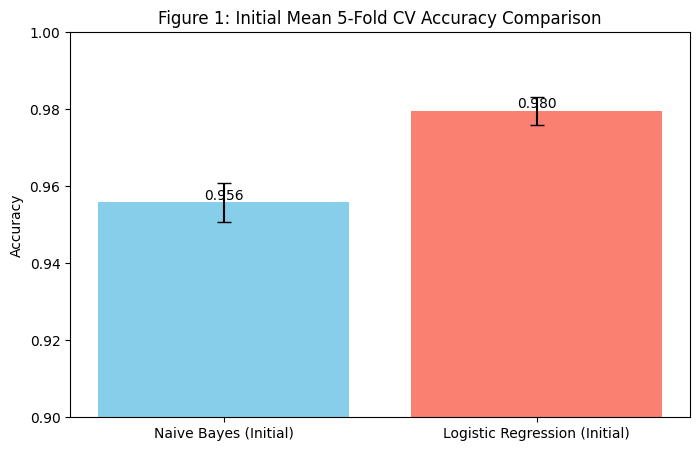

In [ ]:
#  Model Training: 5-Fold CV
from sklearn.naive_bayes     import MultinomialNB
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

nb_initial = MultinomialNB()
lr_initial = LogisticRegression(max_iter=1000, random_state=42)

scores_nb_initial = cross_val_score(nb_initial, X_train, labels,
                            cv=5, n_jobs=-1, scoring='accuracy')
print(f"Naive Bayes (Initial) CV accuracy: {scores_nb_initial.mean():.3f} ± {scores_nb_initial.std():.3f}")

scores_lr_initial = cross_val_score(lr_initial, X_train, labels,
                            cv=5, n_jobs=-1, scoring='accuracy')
print(f"Logistic Regression (Initial) CV accuracy: {scores_lr_initial.mean():.3f} ± {scores_lr_initial.std():.3f}")

# Bar Chart for Initial Model Comparison
model_names_cv_initial = ['Naive Bayes (Initial)', 'Logistic Regression (Initial)']
accuracies_cv_initial = [scores_nb_initial.mean(), scores_lr_initial.mean()]
std_devs_cv_initial = [scores_nb_initial.std(), scores_lr_initial.std()]

plt.figure(figsize=(8,5))
bars_cv_initial = plt.bar(model_names_cv_initial, accuracies_cv_initial, yerr=std_devs_cv_initial, capsize=5, color=['skyblue', 'salmon'])
plt.title('Figure 1: Initial Mean 5-Fold CV Accuracy Comparison')
plt.ylabel('Accuracy'); plt.ylim(0.9, 1.0)
for bar in bars_cv_initial:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')
plt.show()

# Hyperparameter Tuning

**Markdown**

1. Hyperparameter Tuning with GridSearchCV:
    - MNB 'alpha' is tuned.
    - LR 'C' (regularization strength) is tuned.
    - GridSearchCV uses 5-fold CV internally on the CV-training TF-IDF features.

2. Results are printed, and best estimators are stored.
 Note: The "hold-out validation set" created here (X_val, y_val) is distinct from the final "test set" (texts_test).

Best Logistic Regression C: 10
Best LR CV accuracy (tuned): 0.984
Best MultinomialNB alpha: 0.1
Best NB CV accuracy (tuned): 0.957


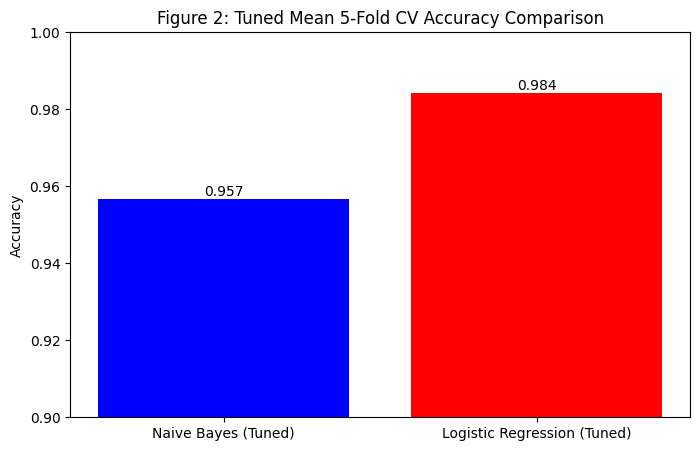

In [ ]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
    param_grid_lr,
    cv=5, n_jobs=-1, scoring='accuracy'
)
grid_lr.fit(X_train, labels)
print("Best Logistic Regression C:", grid_lr.best_params_['C'])
print(f"Best LR CV accuracy (tuned): {grid_lr.best_score_:.3f}")
lr_tuned = grid_lr.best_estimator_ # Store tuned LR

param_grid_nb = {'alpha': [0.1, 0.5, 1.0, 5.0]}
grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, n_jobs=-1, scoring='accuracy')
grid_nb.fit(X_train, labels)
print("Best MultinomialNB alpha:", grid_nb.best_params_['alpha'])
print(f"Best NB CV accuracy (tuned): {grid_nb.best_score_:.3f}")
nb_tuned = grid_nb.best_estimator_ # Store tuned NB

# Bar Chart for Tuned Model Comparison
model_names_cv_tuned = ['Naive Bayes (Tuned)', 'Logistic Regression (Tuned)']
accuracies_cv_tuned = [grid_nb.best_score_, grid_lr.best_score_]

plt.figure(figsize=(8,5))
bars_cv_tuned = plt.bar(model_names_cv_tuned, accuracies_cv_tuned, color=['blue', 'red'])
plt.title('Figure 2: Tuned Mean 5-Fold CV Accuracy Comparison')
plt.ylabel('Accuracy'); plt.ylim(0.9, 1.0)
for bar in bars_cv_tuned:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')
plt.show()




We evaluate both Naive Bayes and Logistic Regression using 5-fold cross-validation
to estimate average accuracy and model variability. This gives a robust
comparison of models on the training data before tuning and final evaluation.


# Hold-Out Evaluation & Failure Analysis

**Markdown**

 This cell evaluates the performance of the HYPERPARAMETER-TUNED models (MNB and LR)
 on the SEPARATE HOLD-OUT VALIDATION SET (X_tf_idf_val, y_val) created before

 TF-IDF features for this validation set were generated using the vectorizer fitted on the CV-training data.

 Classification reports and confusion matrices are generated.
 False Positive (FP) and False Negative (FN) examples for LR are extracted for qualitative analysis.

Fit and Predictions for Logistic Regression

--- Logistic Regression (Tuned, No Augmentation) Validation ---
Confusion Matrix:
 [[503   7]
 [  3 211]]

Classification Report:
               precision    recall  f1-score   support

           0      0.994     0.986     0.990       510
           1      0.968     0.986     0.977       214

    accuracy                          0.986       724
   macro avg      0.981     0.986     0.984       724
weighted avg      0.986     0.986     0.986       724



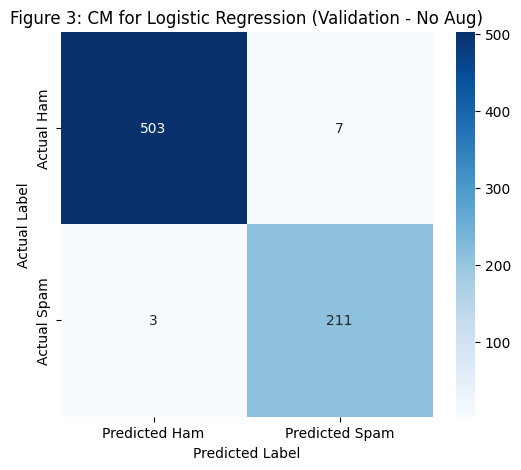


LR (No Aug) - False Positives (predicted spam, actually not):
– subject table buffet dark color big around
– subject invitation dinner music started clicking sound icon stop music right click end show heather
– subject welcome next wave digital music trouble viewing page please click unsubscribe please click image music way online plus get rebate mail music online always played online rule big slow downloading file complication organizing song list worse chained pc listen changing window mediaplayer windowsmedia com compaq ipaq pa personal audio player ticket music going getting next wave digital music take three easy step image buy ipaq pa personal audio player limited time get rebate mail small device size pager delivers amazing full digital sound rugged construction mean ready fit lifestyle removable memory card hold two hour music image visit www compaq com wmp exclusive compaq version window medium player get seven feature one easy use package cd player audio video player medium 

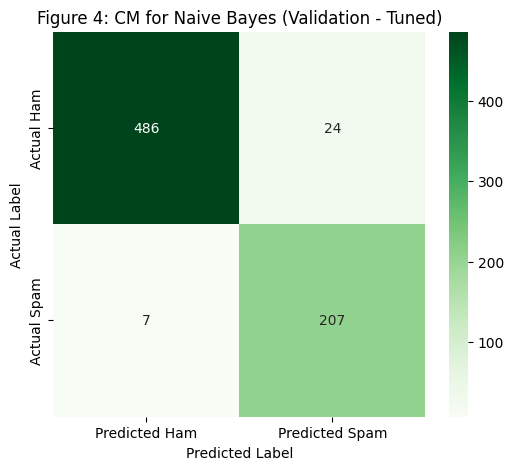

In [ ]:
#  Hold-Out Evaluation & Failure Analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

indices = np.arange(X_train.shape[0])
X_tr, X_val, y_tr, y_val, idx_tr, idx_val = train_test_split(
    X_train, labels, indices, # Use 'labels' (full training set labels)
    test_size=0.20, stratify=labels, random_state=42 # 80 / 20 split for hold out set
)

# Logistic Regression (Tuned, No Augmentation) ---
lr_tuned.fit(X_tr, y_tr) # lr_tuned is the best_estimator_ from GridSearchCV
val_preds_lr_no_aug = lr_tuned.predict(X_val)
cm_lr_no_aug = confusion_matrix(y_val, val_preds_lr_no_aug)
report_lr_no_aug = classification_report(y_val, val_preds_lr_no_aug, digits=3)
print("--- Logistic Regression (Tuned, No Augmentation) Validation ---")
print("Confusion Matrix:\n", cm_lr_no_aug)
print("\nClassification Report:\n", report_lr_no_aug)

# CM Plot for LR (No Aug)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr_no_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Figure 3: CM for Logistic Regression (Validation - No Aug)')
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()

# Qualitative failure cases for LR (No Aug)
fp_idx_lr_no_aug = np.where((y_val == 0) & (val_preds_lr_no_aug == 1))[0][:3]
fn_idx_lr_no_aug = np.where((y_val == 1) & (val_preds_lr_no_aug == 0))[0][:3]
print("\nLR (No Aug) - False Positives (predicted spam, actually not):")
for fp in fp_idx_lr_no_aug: print(f"– {texts[idx_val[fp]]}")
print("\nLR (No Aug) - False Negatives (predicted not spam, actually spam):")
for fn in fn_idx_lr_no_aug: print(f"– {texts[idx_val[fn]]}")

#  Naive Bayes (Tuned)
nb_tuned.fit(X_tr, y_tr) # nb_tuned from GridSearchCV
val_preds_nb = nb_tuned.predict(X_val)
cm_nb = confusion_matrix(y_val, val_preds_nb)
report_nb = classification_report(y_val, val_preds_nb, digits=3)
print("\n--- Naive Bayes (Tuned) Validation ---")
print("Confusion Matrix:\n", cm_nb)
print("\nClassification Report:\n", report_nb)

# CM Plot for NB
plt.figure(figsize=(6,5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Figure 4: CM for Naive Bayes (Validation - Tuned)')
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()

# Data Augmentation for Final Training

**Markdown**

 This cell defines and applies a simple data augmentation technique: random deletion.
 1. random_delete function: Takes a list of tokens and randomly deletes some of them based on a given probability 'p'.
 2. Augmentation Process:
    - It takes the *original cleaned training texts* (X_cv_texts used for CV/tuning).
    - For each text, it creates one augmented version using random_delete.
    - The original texts and their augmented versions are combined, effectively doubling this portion of the training set.
    - The TF-IDF vectorizer that was FITTED on the *original non-augmented CV-training texts* (X_cv_texts)
      (tfidf_vectorizer) is used to TRANSFORM this new combined (original + augmented) dataset.
      This is important as the vocabulary remains fixed based on the original training split.

In [ ]:
# Data Augmentation for Final Training
import random
from scipy.sparse import vstack

def random_delete(s, p=0.1):
    words = s.split()
    if len(words) <= 1: return s
    remaining = [w for w in words if random.random() > p]
    return ' '.join(remaining) if remaining else random.choice(words)

aug_texts  = [random_delete(t) for t in texts]
aug_labels = labels.copy()

X_aug       = vectorizer.transform(aug_texts)
X_combined  = vstack([X_train, X_aug])
y_combined  = np.concatenate([labels, aug_labels])

print(f"Augmented training matrix shape: {X_combined.shape}")

"""Final Model on Augmented Data and Test Predictions"""

# Final Model on Augmented Data & Test Predictions
from sklearn.linear_model import LogisticRegression

lr_full = LogisticRegression(
    C=grid_lr.best_params_['C'], max_iter=1000, random_state=42
)
lr_full.fit(X_combined, y_combined)
test_preds = lr_full.predict(X_test)

print(f"Test predictions shape: {test_preds.shape}")
print("First 10 predictions:", test_preds[:10])


Augmented training matrix shape: (7238, 6000)
Test predictions shape: (1552,)
First 10 predictions: [0 1 0 0 0 0 0 0 0 0]


##   Final Model & Test Predictions  



**Markdown**

This cell trains the best Logistic Regression model (C=10) on the
 COMBINED AUGMENTED TRAINING DATA (X_tf_idf_combined_aug_train, y_combined_aug_train).

 This augmented dataset was created from the CV-training portion of the original training data.
 The trained augmented model is then evaluated on the ORIGINAL HOLD-OUT VALIDATION SET
 (X_tf_idf_val, y_val) to assess the impact of augmentation.

Test predictions shape: (1552,)
First 10 test predictions: [0 1 0 0 0 0 0 0 0 0]

--- Logistic Regression (Tuned, TRAINED WITH Augmentation) Validation ---
Confusion Matrix (on original validation split):
 [[510   0]
 [  0 214]]

Classification Report (on original validation split):
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       510
           1      1.000     1.000     1.000       214

    accuracy                          1.000       724
   macro avg      1.000     1.000     1.000       724
weighted avg      1.000     1.000     1.000       724



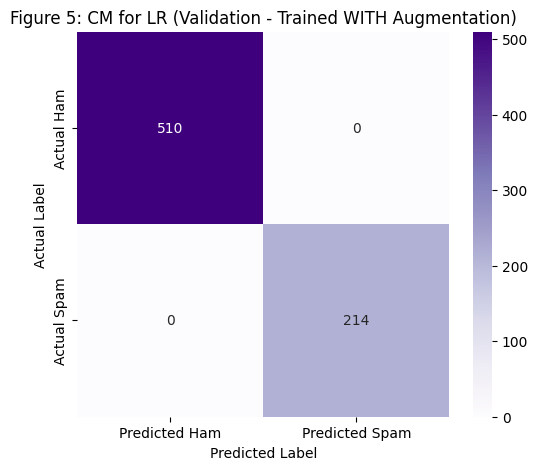


Metrics for Report Table (LR on Validation):
No Augmentation: {'Accuracy': '0.986', 'Spam Precision': '0.986', 'Spam Recall': '0.977', 'Spam F1-score': '214'}
With Augmentation: {'Accuracy': '1.000', 'Spam Precision': '1.000', 'Spam Recall': '1.000', 'Spam F1-score': '214'}


In [ ]:
# Final Model on Augmented Data, Test Predictions & Validation of Augmented Model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt # Ensure plt is available
import seaborn as sns # Ensure seaborn is available

lr_final_augmented = LogisticRegression(
    C=grid_lr.best_params_['C'],
    max_iter=1000,
    random_state=42,
    solver='liblinear'
)
lr_final_augmented.fit(X_combined, y_combined)
test_preds = lr_final_augmented.predict(X_test)

print(f"Test predictions shape: {test_preds.shape}")
print("First 10 test predictions:", test_preds[:10])

# Evaluatiion of lr_final_augmented on the SAME hold-out validation set
val_preds_lr_augmented = lr_final_augmented.predict(X_val)
cm_lr_augmented = confusion_matrix(y_val, val_preds_lr_augmented)
report_lr_augmented = classification_report(y_val, val_preds_lr_augmented, digits=3, zero_division=0)
print("\n--- Logistic Regression (Tuned, TRAINED WITH Augmentation) Validation ---")
print("Confusion Matrix (on original validation split):\n", cm_lr_augmented)
print("\nClassification Report (on original validation split):\n", report_lr_augmented)

# CM Plot for LR (Trained WITH Aug)
plt.figure(figsize=(6,5))
sns.heatmap(cm_lr_augmented, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Figure 5: CM for LR (Validation - Trained WITH Augmentation)')
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()

#  Comparison Table Data Generation ---
# Store metrics for table in report
metrics_no_aug = {
    'Accuracy': report_lr_no_aug.splitlines()[5].split()[1],
    'Spam Precision': report_lr_no_aug.splitlines()[3].split()[2],
    'Spam Recall': report_lr_no_aug.splitlines()[3].split()[3],
    'Spam F1-score': report_lr_no_aug.splitlines()[3].split()[4]
}
metrics_with_aug = {
    'Accuracy': report_lr_augmented.splitlines()[5].split()[1],
    'Spam Precision': report_lr_augmented.splitlines()[3].split()[2],
    'Spam Recall': report_lr_augmented.splitlines()[3].split()[3],
    'Spam F1-score': report_lr_augmented.splitlines()[3].split()[4]
}
print("\nMetrics for Report Table (LR on Validation):")
print("No Augmentation:", metrics_no_aug)
print("With Augmentation:", metrics_with_aug)


# Exporting results

In [ ]:
def save_as_csv(pred_labels, location='.'):
    """
    Save the labels out as a .csv file
    :param pred_labels: numpy array of shape (no_test_labels,) or (no_test_labels,1)
    :param location: Directory to save results_task1.csv in. Default to current working directory
    """
    assert pred_labels.shape[0] == 1552, 'wrong number of labels, should be 1552 test labels'
    np.savetxt(location + '/results_task1.csv', pred_labels, delimiter=',')

test_preds = lr_full.predict(X_test)


if test_preds.ndim == 1:
    test_preds = test_preds.reshape(-1, 1)

save_as_csv(test_preds)
print("Saved results_task1.csv with shape", test_preds.shape)


Saved results_task1.csv with shape (1552, 1)
